<a href="https://colab.research.google.com/github/nTrouvain/Timeseries-Sequence-Processing-2021/blob/main/TD3_RNNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TD3 part 1 - Multivariate timeseries forecasting using RNNs

Some useful translations, just in case:
- **multivariate**: multivarié.e, phénomène décrit par plusieurs variables statistiques
- **forecast**: prévision
- **dew**: rosée (du matin)

Some interesting content to dive deeper and/or go further about RNNs, or that might help you during the TD:

- [Keras guide about RNNs](https://www.tensorflow.org/guide/keras/rnn)
- [Christopher Olah's blog about LSTM](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) (all his blog posts are great by the way)
- [A very nice experimentation to play with LSTM](https://distill.pub/2016/handwriting/) (to go further) (this will actually probably be the part 2 of this TD)

In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from sklearn import preprocessing

## 1. Analysis

For this exercise, we will use a timeseries representing the pollution level in Beijing, China from 2010 to 2015, along with some weather related variables. Pollution level and weather are recorded every hour.

This is a **multivariate** timeseries: this timeseries represents the evolution of 8 different features: pollution level, dew point, temperature, atmospheric pressure, wind direction, wind speed, snow and rain. The features may not be 
independent: they influence each other in time, and we can use them together
for forecasting.

In this exercise, therefore consider a timeseries composed of 8 variables $\{X_1, X_2, \dots, X_8\}$, where $X_1$ is the pollution level. We want to predict
$X_1[t+1]$ given $X_1[t], X_2[t], \dots, X_8[t]$, i.e. the pollution level during the next hour given the pollution level and the weather during the previous hour.

In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/pollution.csv', index_col=0)

time_index = pd.DatetimeIndex(pd.to_datetime(df[["year", "month", 
                                                 "day", "hour"]]))
df = df.set_index(time_index)

df = df.drop(["year", "month", "day", "hour"], axis=1)
df.columns = ["pollution", "dew", "temp", "press", "wind_dir",
              "wind_speed", "snow", "rain"]

# First 24 hours are NaN
df = df[24:]

# Remove other NaN (copying previous non-NaN value)
df = df.fillna(method="ffill")

# Encode wind direction (NE, NW...) as an integer label (NE=0, NW=1, ...)
wind_direction = df["wind_dir"]
oh_encoder = preprocessing.LabelEncoder().fit(wind_direction)
df["wind_dir"] = oh_encoder.transform(wind_direction)

In [4]:
df.head()

,pollution,dew,temp,press,wind_dir,wind_speed,snow,rain
2010-01-02 00:00:00,129.0,-16,-4.0,1020.0,2,1.79,0,0
2010-01-02 01:00:00,148.0,-15,-4.0,1020.0,2,2.68,0,0
2010-01-02 02:00:00,159.0,-11,-5.0,1021.0,2,3.57,0,0
2010-01-02 03:00:00,181.0,-7,-5.0,1022.0,2,5.36,1,0
2010-01-02 04:00:00,138.0,-7,-5.0,1022.0,2,6.25,2,0


**Some statistics**

**Question: Create a small dashboard with some statistics about the timeseries:**
- a run plot, and your hypotheses on the nature of the timeseries;
- descriptive statistics (min, max, mean, standard deviation, normality test, 
autocorrelation, seasonality, stationarity... you don't have to use them all,
find the ones that suit the best your needs)
- cross-correlation: same as autocorrelation, but this time evaluate if a 
variable is correlated with another (not with itself): have a look at Matplotlib `xcorr` function or Numpy `corrcoef` function. For instance, compute cross-correlation of pollution against temperature or pressure.

In [75]:
# Your answer here...

## 2. Preprocessing

Before using a RNN to forecast this timeseries, we need to ensure that the dataset is conform to the method we want to use.

The preprocessing is performed in 3 steps:

1. **Rescale**: neural networks work better on variable following bounded distributions. A simple rescaling method is to make sure that all values are within the $[0, 1]$ interval.
2. **Reshape**: make sure that the dataset shape is following the model needs. In our case, we want to perform what is called **many-to-one** inference: some past point of the series are used to predict one future point, like in an AR model. We will first focus on making a simple **one-to-one** prediction,
where the previous point of the series is used to predict the next one.
3. **Split**: we want to split the dataset between a training sequence and a testing sequence (as usual, but making sure that we do not break the temporal dependency!)

**Question: complete the following cells to preprocess the data.**

*Some help:*

- To rescale the data, have a look at scikit-learn `MinMaxScaler`.
- To reshape the data, have a look at Tensorflow RNN specifications, as this is the tool we will use. You should find out that RNN expects data of shape `(n_timesteps, n_features)`. In our case, for one-to-one prediction, we can say that `n_timesteps` is equal to 1, because we use only one previous timestep to predict the next one.
- Start with only one year of data for training, it should be enough.

### Rescale

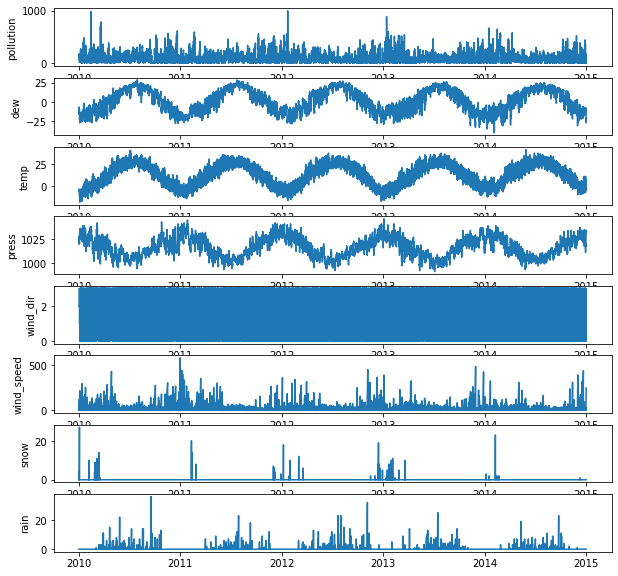

In [76]:
# here is a plot of the current dataset
fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 10))
for i, c in enumerate(df.columns):
    axes[i].plot(df[c])
    axes[i].set_ylabel(c)
plt.show()

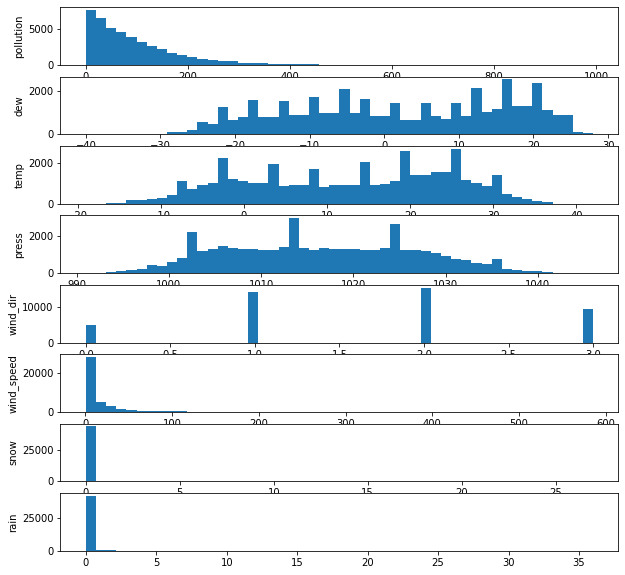

In [77]:
# And here is the current distribution of the variables
fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 10))
for i, c in enumerate(df.columns):
    axes[i].hist(df[c], bins=50)
    axes[i].set_ylabel(c)
plt.show()

In [80]:
# Use the MinMaxScaler from scikit-learn to rescale all variables between 0 and 1
# and store the dataset as a numpy array in the 'data' variable.
...
data = ...

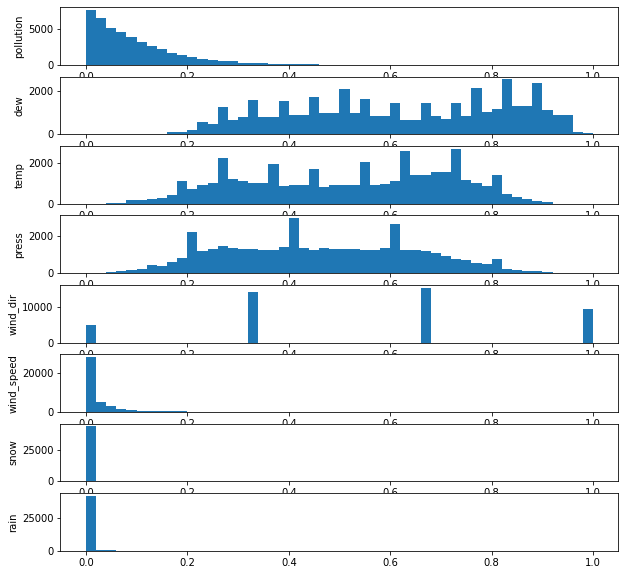

In [79]:
# Here is the new distribution of variables
fig, axes = plt.subplots(len(df.columns), 1, figsize=(10, 10))
for i, c in enumerate(df.columns):
    axes[i].hist(data[:, i], bins=50)
    axes[i].set_ylabel(c)
plt.show()

### Reshape

In [ ]:
# change the shape of data to allow the training with a Tensorflow RNN
# this should be a 3D array
data = ...

### Split

Select the first year of data to build the training set,
and put all the remaining data in the testing set.

Also, create some ground truth vectors for training:
We want to predict $X_1[t+1]$ given $X_1[t], X_2[t], \dots, X_8[t]$. Therefore,
this problem can be seen as a supervised learning problem, where $X_1[t+1]$ are the `y_train` vectors and $X_1[t], X_2[t], \dots, X_8[t]$ are the `X_train` vectors. The model then fits `y_train` given `X_train`.

In [48]:
one_year = 365 * 24  # one point per hour, remember!
n_features = data.shape[2]

X_train = ...
y_train = ...

# same with test values
X_test = ...
y_test = ...

In [50]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((8759, 1, 8), (8759,), (35039, 1, 8), (35039,))

## Model

**Question: now, create a model to forecast the timeseries.**

*Some help:*
- First, try out the `SimpleRNN` from Tensorflow, which is an Elman network
that can be trained with backpropagation through time. Then, try out more elaborate models like LSTM.
- Do not forget to evaluate your model! You can add some testing data in the 
`fit` function using the `validation_data` parameter: this data will be used
to compute some test metrics at the end of each epoch (this is called *validation data* then, and should not be taken from the testing dataset, but we can make an exception for this time).
- Next step is to adjust the "Reshape" phase of preprocessing to perform many-to-one inference and to truly exploit the full potential of RNNs. In many-to-one inference, we predict $X_1[t+1]$ given $X_1[t], X_2[t], \dots, X_8[t]$, but also $X_1[t-1], X_2[t-1], \dots, X_8[t-1]$, and so on until $X_1[t-p], X_2[t-p], \dots, X_8[t-p]$, where $p$ is the size of window we want to use. This is similar in form to setting the $p$ parameter in an AR model. In that case, the RNN will exploit its memory of the $p$ past inputs to predict the next value.

In [51]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, SimpleRNN, LSTM

# Create a Keras model
simple_rnn = Sequential([
    SimpleRNN(50, input_shape=(X_train.shape[1], X_train.shape[2])),  # you can play with the stateful parameter...
    Dense(1)
])

simple_rnn.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_7 (LSTM)               (None, 50)                11800     
                                                                 
 dense_7 (Dense)             (None, 1)                 51        
                                                                 
Total params: 11,851
Trainable params: 11,851
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Compile and fit the model. The loss should be a regression loss like the 
# Mean Absolute Error ("mae" in keras/tensorflow).
simple_rnn.compile(...)
hist = simple_rnn.fit(..., shuffle=False) # let shuffle to False, especially if you played with the stateful parameter

Epoch 1/20
122/122 [==============================] - 4s 12ms/step - loss: 0.0599 - val_loss: 0.0497
Epoch 2/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0373 - val_loss: 0.0478
Epoch 3/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0220 - val_loss: 0.0404
Epoch 4/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0162 - val_loss: 0.0356
Epoch 5/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0148 - val_loss: 0.0232
Epoch 6/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0143 - val_loss: 0.0178
Epoch 7/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0141 - val_loss: 0.0163
Epoch 8/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0139 - val_loss: 0.0154
Epoch 9/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 0.0151
Epoch 10/20
122/122 [==============================] - 1s 8ms/step - loss: 0.0140 - val_loss: 0.015

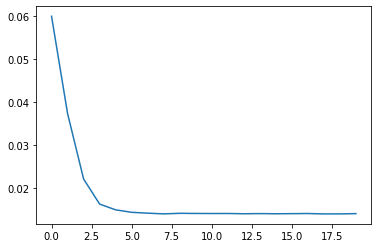

In [53]:
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="test")

In [81]:
# You can compute additional metrics on the test dataset using the 'predict' method.
# Don't forget to use the `inverse_transform` method of the MinMaxScaler then !
# Otherwise, your predictions will remain stuck between 0 and 1.